In [206]:
import torch
import torch.cuda
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests, tarfile
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [207]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using cuda


In [208]:
dataPath = 'UTKFace'
if (dataPath not in os.listdir()):
    print("Downloading UTKFace...")
    url = "https://drive.google.com/uc?export=download&id=0BxYys69jI14kYVM3aVhKS1VhRUk&confirm=t&uuid=f981ca1d-ba0f-40c9-a4a0-8eaa887f3b6d&at=ANzk5s7e36SgjT0FlqBbRiijefRg:1681897584880"

    response = requests.get(url, stream=True)
    file = tarfile.open(fileobj=response.raw, mode="r|gz")
    file.extractall(path=".")
    print("Download complete.")
else:
    print("UTKFace already downloaded.")

UTKFace already downloaded.


In [209]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataPath, transform=None):
        self.dataPath = dataPath
        self.transform = transform
        self.imagePaths = [f for f in os.listdir(self.dataPath) if f.endswith('.jpg')]
        
    def __getitem__(self, index):
        imagePath = self.imagePaths[index]
        try:
            imageTensor = torchvision.io.read_image(f'{self.dataPath}/{imagePath}').float()
            fileName = imagePath.split('_')
            label = torch.Tensor([int(fileName[0]), int(fileName[1]), int(fileName[2])])
            if self.transform:
                imageTensor = self.transform(imageTensor)
            return imageTensor, label
        except:
            return self.__getitem__((index + 1) % len(self.imagePaths))
        
    def __len__(self):
        return len(self.imagePaths)

In [210]:
# Load and normalizde the data
transform = transforms.Compose(
    [transforms.Resize(224, antialias=True),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = MyDataset(dataPath, transform=transform)

batchSize = 100
testSplit = 0.1 # use 10% of dataset as test
validSplit = 0.2 / (1-testSplit) # use 20% of dataset as validation

testSize = int(np.floor(len(dataset)*testSplit))
trainValidSize = int(np.ceil(len(dataset)*(1-testSplit)))
validSize = int(np.ceil(trainValidSize*validSplit))
trainSize = int(np.floor(trainValidSize*(1-validSplit)))
print(len(dataset), testSize, trainValidSize)

trainValidSet, testSet = torch.utils.data.random_split(dataset, [trainValidSize, testSize])
trainSet, validSet = torch.utils.data.random_split(trainValidSet, [trainSize, validSize])

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True)
validLoader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=False)

23708 2370 21338


In [211]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel,self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad=False
        self.resnet.fc = nn.Linear(512, 512)
        self.ageHidden = nn.Linear(512,512)
        self.genderHidden = nn.Linear(512,512)
        self.ethnicityHidden = nn.Linear(512,512)
        self.ageFc = nn.Linear(512,1)
        self.genderFc = nn.Linear(512,2)
        self.ethnicityFc = nn.Linear(512,5)
    
    def forward(self, x):
        resOut = F.relu(self.resnet.forward(x))
        ageX = F.relu(self.ageHidden(resOut))
        ageOut = self.ageFc(ageX)
        genderX = F.relu(self.genderHidden(resOut))
        genderOut = F.sigmoid(self.genderFc(genderX))
        ethnicityX = F.relu(self.ethnicityHidden(resOut))
        ethnicityOut = F.softmax(self.ethnicityFc(ethnicityX), dim=1)
        return ageOut, genderOut, ethnicityOut

    def unfreeze(self):
        for param in self.resnet.parameters():
            param.requires_grad=True

In [212]:
# ResNetModel()

In [213]:
def lossAge(predictAge, targetAge):
    loss = torch.sqrt(F.mse_loss(predictAge, targetAge))
    return loss

def lossGender(predictGender, targetGender):
    loss = F.binary_cross_entropy(predictGender, targetGender)
    return loss

def lossEthnicity(predictEthnicity, targetEthnicity):
    loss = F.cross_entropy(predictEthnicity, targetEthnicity)
    return loss

def lossFunction(predictAge, predictGender, predictEthnicity, targetAge, targetGender, targetEthnicity):
    alpha = 1/6 # weight for age prediction
    beta = 1/3 # weight for gender prediction
    gamma = 1 # weight for ethncity prediction
    ageLoss = lossAge(predictAge, targetAge)
    genderLoss = lossGender(predictGender, targetGender)
    ethnicityLoss = lossEthnicity(predictEthnicity, targetEthnicity)
    totalLoss = alpha * ageLoss + beta * genderLoss + gamma * ethnicityLoss
    return totalLoss, ageLoss, genderLoss, ethnicityLoss

In [214]:
def trainNetwork(model, optimizer, lossFunction, trainLoader, validLoader, epochs, unfreezeEpoch, device, modelPath):
    model.train()
    trainLoaderSize = len(trainLoader)
    validLoaderSize = len(validLoader)
    for epoch in tqdm(range(1, epochs + 1)):
        if epoch == unfreezeEpoch:
            model.unfreeze()
            print("Unfreeze the model for the last 7 epochs")
        
        ### TRAINING ###
        trainAgeLoss, trainGenderLoss, trainEthnicityLoss = 0, 0, 0
        correctTrain = 0
        totalTrain = 0
        for batch_nr, (images, labels) in enumerate(trainLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.long().to(device) 

            ageLabels = labels[:, 0].view(-1, 1).float()
            genderLabels = F.one_hot(labels[:, 1], num_classes=2).float()
            ethnicityLabels = F.one_hot(labels[:, 2], num_classes=5).float()

            # Predict
            agePredictions, genderPredictions, ethnicityPredictions = model(images)

            # Get loss and backpropogate
            totalLoss, ageLoss, genderLoss, ethnicityLoss = lossFunction(agePredictions, genderPredictions, ethnicityPredictions, 
                                                            ageLabels, genderLabels, ethnicityLabels)
            
            totalLoss.backward()

            # Optimize parameters (weights and biases) and remove gradients after
            optimizer.step() 
            optimizer.zero_grad()

            # Save loss for whole epoch
            trainAgeLoss += ageLoss.item()
            trainGenderLoss += genderLoss.item()
            trainEthnicityLoss += ethnicityLoss.item()
            
        trainAgeLoss /= trainLoaderSize
        trainGenderLoss /= trainLoaderSize
        trainEthnicityLoss /= trainLoaderSize
        #trainAccuracy = 100 * correctTrain / totalTrain

        ### VALIDATION ###
        validAgeLoss, validGenderLoss, validEthnicityLoss = 0, 0, 0
        correctValid = 0
        totalValid = 0
        for batch_nr, (images, labels) in enumerate(validLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.long().to(device) 

            ageLabels = labels[:, 0].view(-1, 1).float()
            genderLabels = F.one_hot(labels[:, 1], num_classes=2).float()
            ethnicityLabels = F.one_hot(labels[:, 2], num_classes=5).float()

            # Predict            
            agePredictions, genderPredictions, ethnicityPredictions = model(images)

            # Get loss
            totalLoss, ageLoss, genderLoss, ethnicityLoss = lossFunction(agePredictions, genderPredictions, ethnicityPredictions, 
                                                            ageLabels, genderLabels, ethnicityLabels)
            
            # Save loss for whole epoch
            validAgeLoss += ageLoss.item()
            validGenderLoss += genderLoss.item()
            validEthnicityLoss += ethnicityLoss.item()

        validAgeLoss /= validLoaderSize
        validGenderLoss /= validLoaderSize
        validEthnicityLoss /= validLoaderSize
        #validAccuracy = 100 * correctValid / totalValid

        # Print reuslt of epoch
        print(f'\n\tTraining Losses:   (Age: {trainAgeLoss:.4f}, Gender: {trainGenderLoss:.4f}, Ethnicity: {trainEthnicityLoss:.4f})\t'
              f'\n\tValidation Losses: (Age: {validAgeLoss:.4f}, Gender: {validGenderLoss:.4f}, Ethnicity: {validEthnicityLoss:.4f})\t')
        
    torch.save(model, modelPath)
    print(f"Saved model to {modelPath}")

In [215]:
resnetModel = ResNetModel().to(device)

In [216]:
epochs = 10
unfreezeEpoch = 4
learningRate = 2e-2

modelPath = "resnet18.pth"

optimizer = torch.optim.SGD(resnetModel.parameters(), lr=learningRate)

trainNetwork(resnetModel, optimizer, lossFunction, trainLoader, validLoader, epochs, unfreezeEpoch, device, modelPath)

 10%|█         | 1/10 [01:03<09:29, 63.24s/it]


	Training Losses:   (Age: 21.9717, Gender: 0.6820, Ethnicity: 1.5079)	
	Validation Losses: (Age: 16.7166, Gender: 0.6704, Ethnicity: 1.4777)	


 20%|██        | 2/10 [02:08<08:34, 64.32s/it]


	Training Losses:   (Age: 15.3418, Gender: 0.6549, Ethnicity: 1.4784)	
	Validation Losses: (Age: 14.4738, Gender: 0.6443, Ethnicity: 1.4733)	


 30%|███       | 3/10 [03:11<07:25, 63.68s/it]


	Training Losses:   (Age: 14.1014, Gender: 0.6359, Ethnicity: 1.4747)	
	Validation Losses: (Age: 13.5855, Gender: 0.6300, Ethnicity: 1.4713)	
Unfreeze the model for the last 7 epochs


 40%|████      | 4/10 [04:46<07:37, 76.20s/it]


	Training Losses:   (Age: 10.4246, Gender: 0.6263, Ethnicity: 1.4711)	
	Validation Losses: (Age: 8.7919, Gender: 0.6111, Ethnicity: 1.4642)	


 50%|█████     | 5/10 [06:28<07:07, 85.59s/it]


	Training Losses:   (Age: 7.8000, Gender: 0.5803, Ethnicity: 1.4592)	
	Validation Losses: (Age: 8.5530, Gender: 0.5447, Ethnicity: 1.4408)	


 60%|██████    | 6/10 [08:03<05:54, 88.61s/it]


	Training Losses:   (Age: 6.8206, Gender: 0.5030, Ethnicity: 1.4166)	
	Validation Losses: (Age: 8.1854, Gender: 0.4521, Ethnicity: 1.3938)	


 70%|███████   | 7/10 [09:41<04:34, 91.62s/it]


	Training Losses:   (Age: 5.9651, Gender: 0.4069, Ethnicity: 1.3642)	
	Validation Losses: (Age: 8.7012, Gender: 0.3696, Ethnicity: 1.3507)	


 80%|████████  | 8/10 [11:15<03:05, 92.54s/it]


	Training Losses:   (Age: 5.5107, Gender: 0.3375, Ethnicity: 1.3331)	
	Validation Losses: (Age: 8.3858, Gender: 0.3211, Ethnicity: 1.3315)	


 90%|█████████ | 9/10 [12:50<01:33, 93.23s/it]


	Training Losses:   (Age: 5.0884, Gender: 0.2957, Ethnicity: 1.3147)	
	Validation Losses: (Age: 7.8844, Gender: 0.2941, Ethnicity: 1.3192)	


100%|██████████| 10/10 [14:24<00:00, 86.43s/it]


	Training Losses:   (Age: 4.8087, Gender: 0.2703, Ethnicity: 1.3015)	
	Validation Losses: (Age: 9.2857, Gender: 0.2792, Ethnicity: 1.3099)	
Saved model to resnet18.pth


In [217]:
#model = torch.load(modelPath)
#model.eval()

In [218]:
#for name, param in resnetModel.named_parameters():
#    print(name, param.requires_grad)

In [219]:
def testNetwork(model, testLoader, device):
    model.eval()
    correctAge, correctGender, correctEthnicity = 0, 0, 0
    correctTest = 0
    totalTest = 0

    allAgePredictions = torch.tensor([], dtype=torch.float32).to(device)
    allGenderPredictions = torch.tensor([], dtype=torch.long).to(device)
    allEthnicityPredictions = torch.tensor([], dtype=torch.long).to(device)
    allAgeLabels = torch.tensor([], dtype=torch.float32).to(device)
    allGenderLabels = torch.tensor([], dtype=torch.long).to(device)
    allEthnicityLabels = torch.tensor([], dtype=torch.long).to(device)

    ### TESTING ###
    with torch.no_grad(): 
        for batch_nr, (images, labels) in enumerate(testLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.to(device)  

            ageLabels = labels[:, 0]
            genderLabels = labels[:, 1]
            ethnicityLabels = labels[:, 2]
            
            # Get predictions and get the amount of correct predicitons
            agePredictions, genderPredictions, ethnicityPredictions = model(images)

            agePredictions = torch.round(agePredictions).view(1, -1)
            correctAge += ((agePredictions - ageLabels).abs() <= 3).sum().item()

            _, genderPredictions = torch.max(genderPredictions, 1) 
            correctGender += (genderPredictions == genderLabels).sum().item() 

            _, ethnicityPredictions = torch.max(ethnicityPredictions, 1) 
            correctEthnicity += (ethnicityPredictions == ethnicityLabels).sum().item() 

            totalTest += len(images)
            
            # concatenate the predictions and labels of each batch
            allAgePredictions = torch.cat((allAgePredictions, agePredictions), dim=1)
            allGenderPredictions = torch.cat((allGenderPredictions, genderPredictions), dim=0)
            allEthnicityPredictions = torch.cat((allEthnicityPredictions, ethnicityPredictions), dim=0)
            allAgeLabels = torch.cat((allAgeLabels, ageLabels), dim=0)
            allGenderLabels = torch.cat((allGenderLabels, genderLabels), dim=0)
            allEthnicityLabels = torch.cat((allEthnicityLabels, ethnicityLabels), dim=0)

    ageAccuracy = 100 * correctAge / totalTest
    genderAccuracy = 100 * correctGender / totalTest
    ethnicityAccuracy = 100 * correctEthnicity / totalTest

    print(f"Test Accuracy: (Age +/-3 years: {ageAccuracy:.2f}%, Gender: {genderAccuracy:.2f}%, Ethnicity: {ethnicityAccuracy:.2f}%)")
    return allAgePredictions, allGenderPredictions, allEthnicityPredictions, allAgeLabels, allGenderLabels, allEthnicityLabels

In [220]:
agePredictions, genderPredictions, ethnicityPredictions, ageLabels, genderLabels, ethnicityLabels = testNetwork(resnetModel, validLoader, device)

Test Accuracy: (Age +/-3 years: 40.53%, Gender: 88.82%, Ethnicity: 59.45%)


In [221]:
agePredictions, ageLabels

(tensor([[ 3., 57., 38.,  ..., 24., 32., 62.]], device='cuda:0'),
 tensor([ 1., 76., 44.,  ..., 27., 35., 61.], device='cuda:0'))

In [222]:
ethnicityPredictions, ethnicityLabels

(tensor([0, 1, 1,  ..., 0, 0, 1], device='cuda:0'),
 tensor([4., 1., 1.,  ..., 0., 0., 2.], device='cuda:0'))

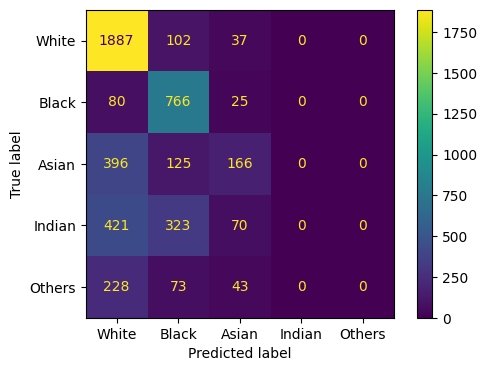

In [223]:

GENDER = ['M', 'F']
ETHNICITY = ['White', 'Black', 'Asian', 'Indian', 'Others']
import pandas as pd
import sklearn.metrics as skmetric

matrix = skmetric.confusion_matrix(ethnicityLabels.cpu(), ethnicityPredictions.cpu())
display = skmetric.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ETHNICITY)
fig, ax = plt.subplots(figsize=(6,4))
display.plot(ax=ax)
plt.show()

#print(skmetric.classification_report(arrayEmotionNumToString(testEncodedEmotionLabel), arrayEmotionNumToString(predTestEncodedEmotionLabel)))

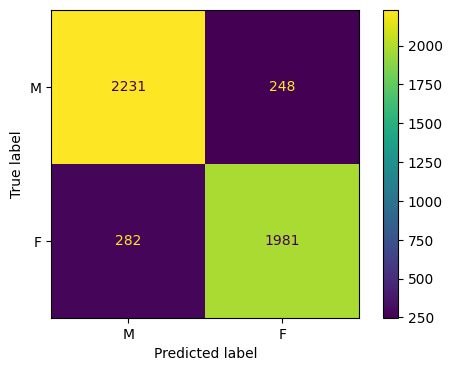

In [224]:
matrix = skmetric.confusion_matrix(genderLabels.cpu(), genderPredictions.cpu())
display = skmetric.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=GENDER)
fig, ax = plt.subplots(figsize=(6,4))
display.plot(ax=ax)
plt.show()

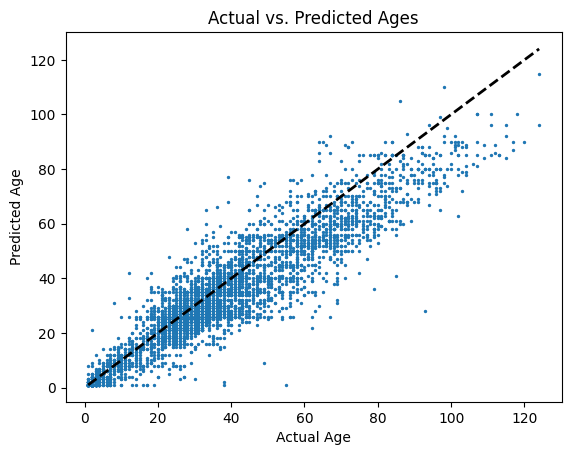

In [225]:
y_test = agePredictions.cpu()[0]
plt.scatter(y_test, ageLabels.cpu(), s=2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],'k--', lw=2)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Actual vs. Predicted Ages')
plt.show()